In [1]:
import keras
keras.__version__
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.
/Users/marek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/marek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/marek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/marek/opt/anaconda3/lib/python3.7/sit

Marek Krauze
Marek Majerski

# 1. Getting Data

In [71]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [72]:
word_index = reuters.get_word_index() #get word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) #encode words
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]]) #decode words
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

# 2. Preparing Data

In [73]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000): #make one hot encoding 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

print(x_train.shape)


def to_one_hot1(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

def to_one_hot(labels, dimension=46):
    results = []
    
    for label in labels:
        results.append(np.asarray([label==i for i in range(0,dimension)],dtype=np.uint8))
        
    return np.asarray(results)
    
# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)



(8982, 10000)


In [74]:
dimension = 46
label = 34
res = np.asarray([label==i for i in range(0,dimension)],dtype=np.uint8)
print(res)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0]


In [75]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print(one_hot_test_labels.shape)

(2246, 46)


# 3. Class weights

In [76]:
import numpy as np

print(train_labels)
counts = np.unique(train_labels,return_counts=True) 


counts = np.asarray(counts)
print(counts.shape)

print(counts)

weights = np.ones(counts.shape[1],dtype=np.float32)
weights = 1/counts[1,:]

w = np.sum(weights)

weights = weights/w #normalization of weights

print(weights)

weightsDict = dict(zip(np.asarray(counts[0,:]),weights))
print(weightsDict)

[ 3  4  3 ... 25  3 25]
(2, 46)
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]
[0.01245548 0.00158577 0.00925745 0.00021686 0.00035149 0.04029715
 0.01427191 0.04281572 0.00492843 0.00678269 0.00552461 0.00175654
 0.01398064 0.00398286 0.02634814 0.03425258 0.00154291 0.01756542
 0.01037957 0.00124782 0.00254666 0.00685052 0.0456701  0.01670857
 0.01104922 0.00744621 0.02854382 0.0456701  0.01427191 0.03605535
 0.01522337 0.01756542 0.02140786 0.06227742 0.01370103 0.06850516
 0.01398064 0.03605535 0.03605535 0.02854382 0.01902921 0.02283505
 0.05269627 0.032621

# 4. Building Network

In [77]:
from keras import models
from keras import layers

#2 hidden layer
model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(46, activation='softmax')) 

#3 hidden layers
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

#1 hidden layers
model3 = models.Sequential()
model3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model3.add(layers.Dense(46, activation='softmax'))

print("1 hidden layer:")
print(model1.summary())
print("2 hidden layers:")
print(model2.summary())
print("4 hidden layers")
print(model3.summary())


1 hidden layer:
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_45 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_46 (Dense)             (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________
None
2 hidden layers:
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_48 (Dense)             (None, 64)             

In [78]:
#2 hidden layer
model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#3 hidden layers
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#1 hidden layers
model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]


print(partial_x_train.shape)
print(partial_y_train.shape)
print(y_val.shape)
print(x_val.shape)

#2 hidden layer
history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),class_weight = weightsDict) #we use class_weight because classes are unbalanced

#3 hidden layers
history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),class_weight = weightsDict)

#1 hidden layers
history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),class_weight = weightsDict)


(7982, 10000)
(7982, 46)
(1000, 46)
(1000, 10000)
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 169us/step - loss: 0.0131 - accuracy: 0.2306 - val_loss: 3.4425 - val_accuracy: 0.4880
Epoch 2/20
7982/7982 [==============================] - 1s 101us/step - loss: 0.0108 - accuracy: 0.5690 - val_loss: 2.9572 - val_accuracy: 0.6280
Epoch 3/20
7982/7982 [==============================] - 1s 92us/step - loss: 0.0082 - accuracy: 0.7249 - val_loss: 2.4855 - val_accuracy: 0.6750
Epoch 4/20
7982/7982 [==============================] - 1s 82us/step - loss: 0.0059 - accuracy: 0.7864 - val_loss: 2.0126 - val_accuracy: 0.7310
Epoch 5/20
7982/7982 [==============================] - 1s 91us/step - loss: 0.0041 - accuracy: 0.8197 - val_loss: 1.6854 - val_accuracy: 0.7550
Epoch 6/20
7982/7982 [==============================] - 1s 91us/step - loss: 0.0029 - accuracy: 0.8465 - val_loss: 1.4591 - val_accuracy: 0.7820
Epoch 7/20
7982/7982 [========

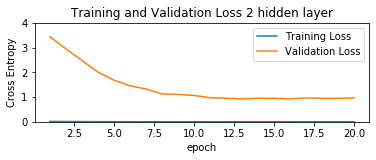

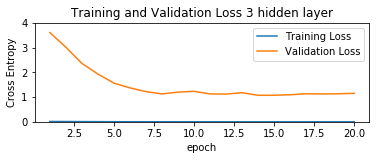

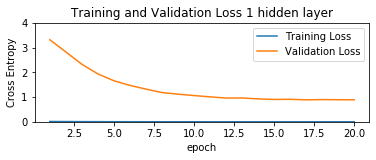

In [80]:
import matplotlib.pyplot as plt

loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss 2 hidden layer')
plt.xlabel('epoch')
plt.show()

loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss 3 hidden layer')
plt.xlabel('epoch')
plt.show()

loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss 1 hidden layer')
plt.xlabel('epoch')
plt.show()




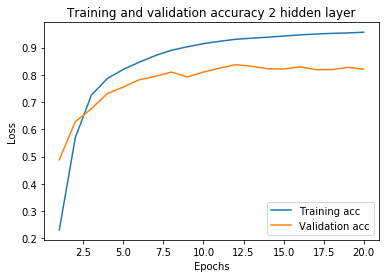

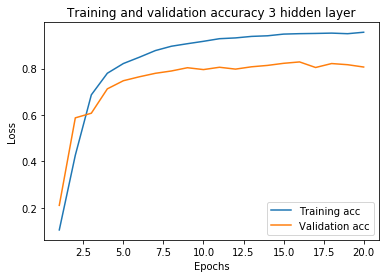

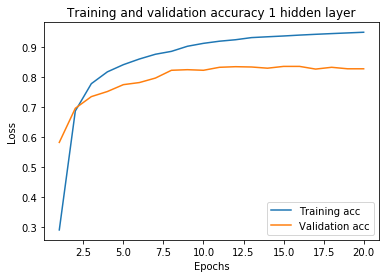

In [81]:
plt.clf()   

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 2 hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 3 hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 1 hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We have an overfitting problem in all 3 cases, 1 hidden layers seems to be the most stable one.

In [82]:


#1 hidden layer
model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(46, activation='softmax'))

model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results1 = model1.evaluate(x_test, one_hot_test_labels)

#2 hidden layers
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results2 = model2.evaluate(x_test, one_hot_test_labels)

#3 hidden layers
model3 = models.Sequential()
model3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(46, activation='softmax'))

model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results3 = model3.evaluate(x_test, one_hot_test_labels)




Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 148us/step - loss: 2.5857 - accuracy: 0.5654 - val_loss: 1.8084 - val_accuracy: 0.6710
Epoch 2/8
7982/7982 [==============================] - 1s 114us/step - loss: 1.4660 - accuracy: 0.7255 - val_loss: 1.3382 - val_accuracy: 0.7290
Epoch 3/8
7982/7982 [==============================] - 1s 122us/step - loss: 1.0590 - accuracy: 0.7945 - val_loss: 1.1329 - val_accuracy: 0.7690
Epoch 4/8
7982/7982 [==============================] - 1s 116us/step - loss: 0.8272 - accuracy: 0.8354 - val_loss: 1.0132 - val_accuracy: 0.7970
Epoch 5/8
7982/7982 [==============================] - 1s 130us/step - loss: 0.6646 - accuracy: 0.8727 - val_loss: 0.9422 - val_accuracy: 0.8190
Epoch 6/8
7982/7982 [==============================] - 1s 118us/step - loss: 0.5432 - accuracy: 0.8939 - val_loss: 0.8969 - val_accuracy: 0.8210
Epoch 7/8
7982/7982 [==============================] - 1s 116us/step - loss: 0.447

In [83]:
print(results1)
print(results2)
print(results3)




[0.9121237888149353, 0.7987533211708069]
[0.986889406706962, 0.7813891172409058]
[1.067194983456035, 0.7773820161819458]


results for 1 hidden layers seems to be the best

In [84]:
from sklearn.metrics import classification_report, confusion_matrix

print("1 hidden layers")

pred_probabilities1 = model1.predict(x_test)
pred_labels1 = np.argmax(pred_probabilities1,-1)

cm = confusion_matrix(test_labels, pred_labels1)
print(cm)
print(classification_report(test_labels, pred_labels1))

print("2 hidden layers")

pred_probabilities2 = model2.predict(x_test)
pred_labels2 = np.argmax(pred_probabilities2,-1)

cm = confusion_matrix(test_labels, pred_labels2)
print(cm)
print(classification_report(test_labels, pred_labels2))

print("3 hidden layers")

pred_probabilities3 = model3.predict(x_test)
pred_labels3 = np.argmax(pred_probabilities3,-1)

cm = confusion_matrix(test_labels, pred_labels3)
print(cm)
print(classification_report(test_labels, pred_labels3))



1 hidden layers
[[ 6  2  0 ...  0  0  0]
 [ 0 86  0 ...  0  0  0]
 [ 0  5 12 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.63      0.82      0.71       105
           2       0.80      0.60      0.69        20
           3       0.92      0.94      0.93       813
           4       0.83      0.90      0.86       474
           5       0.00      0.00      0.00         5
           6       1.00      0.93      0.96        14
           7       1.00      0.33      0.50         3
           8       0.71      0.63      0.67        38
           9       0.80      0.64      0.71        25
          10       0.89      0.80      0.84        30
          11       0.55      0.81      0.65        83
          12       0.33      0.08      0.12        13
          13       0.54      0.70      0.61        37
          14     

/Users/marek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 6  4  0 ...  0  0  0]
 [ 0 85  0 ...  0  0  0]
 [ 0  4 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.57      0.81      0.67       105
           2       0.71      0.50      0.59        20
           3       0.89      0.95      0.92       813
           4       0.82      0.87      0.85       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.65      0.63      0.64        38
           9       0.86      0.72      0.78        25
          10       0.84      0.70      0.76        30
          11       0.58      0.78      0.66        83
          12       0.33      0.08      0.12        13
          13       0.53      0.68      0.60        37
          14       0.00      0.00

# 4. Generating Predictions

In [85]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.18744434550311664

In [86]:
predictions = model1.predict(x_test)
predictions[0].shape
np.sum(predictions[0])
np.argmax(predictions[0])



3

# 5. Sparse Categorical Crossentropy

In [97]:
from keras import models
from keras import layers

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000): #vectorize
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results




# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = train_labels[:1000]
partial_y_train = train_labels[1000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)


(7982, 10000)
(7982,)
(1000, 10000)
(1000,)


In [113]:
# 1 hidden layer
model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(46, activation='softmax'))
model1.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),class_weight = weightsDict)

#2 hidden layers
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),class_weight = weightsDict)

#3 hidden layers

model3 = models.Sequential()
model3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(46, activation='softmax'))

model3.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),class_weight = weightsDict)


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 189us/step - loss: 0.0128 - accuracy: 0.3809 - val_loss: 3.2019 - val_accuracy: 0.6050
Epoch 2/20
7982/7982 [==============================] - 1s 123us/step - loss: 0.0099 - accuracy: 0.7121 - val_loss: 2.7275 - val_accuracy: 0.7180
Epoch 3/20
7982/7982 [==============================] - 1s 114us/step - loss: 0.0075 - accuracy: 0.7967 - val_loss: 2.2760 - val_accuracy: 0.7400
Epoch 4/20
7982/7982 [==============================] - 1s 116us/step - loss: 0.0055 - accuracy: 0.8212 - val_loss: 1.9339 - val_accuracy: 0.7650
Epoch 5/20
7982/7982 [==============================] - 1s 119us/step - loss: 0.0041 - accuracy: 0.8416 - val_loss: 1.7000 - val_accuracy: 0.7760
Epoch 6/20
7982/7982 [==============================] - 1s 116us/step - loss: 0.0030 - accuracy: 0.8603 - val_loss: 1.4676 - val_accuracy: 0.7900
Epoch 7/20
7982/7982 [==============================] - 1s 112us/step - loss

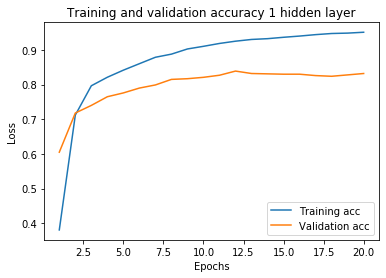

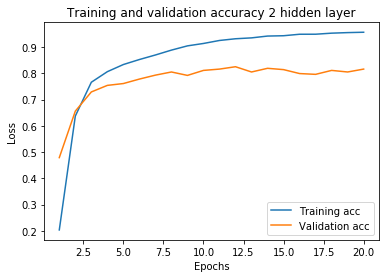

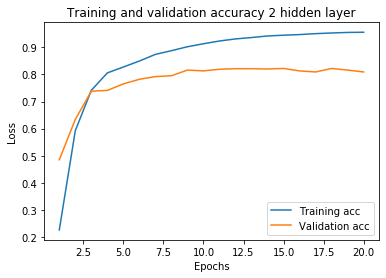

In [114]:

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 1 hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 2 hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 2 hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

overfitting after 11 epochs for 2 hidden layer 

In [115]:
results1 = model1.evaluate(x_test, test_labels)
results2 = model2.evaluate(x_test, test_labels)
print(results1)
print(results2)

2246/2246 [==============================] - 0s 63us/step
[0.9759647926897845, 0.8063223361968994]
[1.1599521123184653, 0.7951914668083191]


1 hidden layer seems to be better

In [116]:
from sklearn.metrics import classification_report, confusion_matrix

print("1 hidden layers")

pred_probabilities1 = model1.predict(x_test)
pred_labels1 = np.argmax(pred_probabilities1,-1)

cm = confusion_matrix(test_labels, pred_labels1)
print(cm)
print(classification_report(test_labels, pred_labels1))

print("2 hidden layers")

pred_probabilities2 = model2.predict(x_test)

pred_labels2 = np.argmax(pred_probabilities2,-1)

cm = confusion_matrix(test_labels, pred_labels2)
print(cm)
print(classification_report(test_labels, pred_labels2))



1 hidden layers
[[ 7  2  0 ...  0  0  0]
 [ 0 84  0 ...  0  0  0]
 [ 0  2 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.66      0.80      0.72       105
           2       0.74      0.70      0.72        20
           3       0.94      0.92      0.93       813
           4       0.85      0.88      0.86       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       0.50      0.33      0.40         3
           8       0.65      0.74      0.69        38
           9       0.87      0.80      0.83        25
          10       0.87      0.90      0.89        30
          11       0.58      0.78      0.67        83
          12       0.50      0.23      0.32        13
          13       0.60      0.57      0.58        37
          14     

/Users/marek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 8  2  0 ...  0  0  0]
 [ 0 89  0 ...  0  0  0]
 [ 0  4 11 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.53      0.85      0.65       105
           2       0.73      0.55      0.63        20
           3       0.94      0.91      0.93       813
           4       0.83      0.87      0.85       474
           5       1.00      0.20      0.33         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.74      0.76      0.75        38
           9       0.86      0.76      0.81        25
          10       0.86      0.83      0.85        30
          11       0.64      0.67      0.66        83
          12       0.50      0.31      0.38        13
          13       0.51      0.62      0.56        37
          14       0.17      0.50

# 5. 64 vs 32 units

In [119]:
def to_one_hot(labels, dimension=46):
    results = []
    
    for label in labels:
        results.append(np.asarray([label==i for i in range(0,dimension)],dtype=np.uint8))
        
    return np.asarray(results)
    
# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]



#1 64
model1 = models.Sequential()
model2 = models.Sequential()

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(4, activation='relu'))
model1.add(layers.Dense(46, activation='softmax'))

model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

#2 32
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model2 = models.Sequential()
model2.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(4, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 182us/step - loss: 3.3766 - accuracy: 0.0626 - val_loss: 2.9034 - val_accuracy: 0.3670
Epoch 2/20
7982/7982 [==============================] - 1s 109us/step - loss: 2.2602 - accuracy: 0.4795 - val_loss: 1.8402 - val_accuracy: 0.6140
Epoch 3/20
7982/7982 [==============================] - 1s 116us/step - loss: 1.4990 - accuracy: 0.6333 - val_loss: 1.5493 - val_accuracy: 0.6180
Epoch 4/20
7982/7982 [==============================] - 1s 115us/step - loss: 1.2953 - accuracy: 0.6651 - val_loss: 1.4877 - val_accuracy: 0.6440
Epoch 5/20
7982/7982 [==============================] - 1s 115us/step - loss: 1.1838 - accuracy: 0.7008 - val_loss: 1.4748 - val_accuracy: 0.6550
Epoch 6/20
7982/7982 [==============================] - 1s 113us/step - loss: 1.1039 - accuracy: 0.7270 - val_loss: 1.4636 - val_accuracy: 0.6720
Epoch 7/20
7982/7982 [==============================] - 1s 115us/step - loss

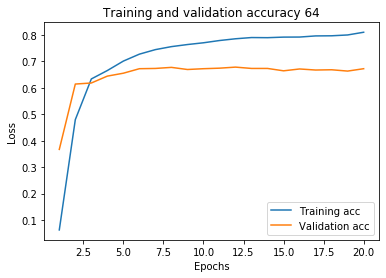

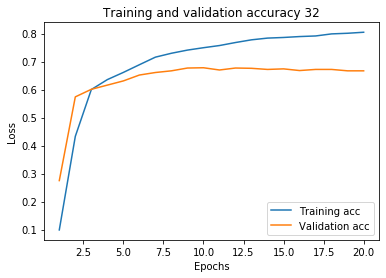

In [120]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 64')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

32 is more stable

In [121]:
from sklearn.metrics import classification_report, confusion_matrix

print("64")

pred_probabilities1 = model1.predict(x_test)
pred_labels1 = np.argmax(pred_probabilities1,-1)

cm = confusion_matrix(test_labels, pred_labels1)
print(cm)
print(classification_report(test_labels, pred_labels1))

print("32s")

pred_probabilities2 = model2.predict(x_test)
pred_labels2 = np.argmax(pred_probabilities2,-1)

cm = confusion_matrix(test_labels, pred_labels2)
print(cm)
print(classification_report(test_labels, pred_labels2))



64
[[ 7  0  0 ...  0  0  0]
 [ 1 50  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 ...
 [ 5  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.13      0.58      0.22        12
           1       0.43      0.48      0.45       105
           2       0.00      0.00      0.00        20
           3       0.86      0.92      0.89       813
           4       0.73      0.86      0.79       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.11      0.03      0.04        38
           9       0.36      0.32      0.34        25
          10       0.33      0.73      0.45        30
          11       0.45      0.58      0.51        83
          12       0.00      0.00      0.00        13
          13       0.27      0.35      0.31        37
          14       0.00      0

/Users/marek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0  3  3 ...  0  0  0]
 [ 0 71  1 ...  0  0  0]
 [ 1  3  1 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.59      0.68      0.63       105
           2       0.04      0.05      0.04        20
           3       0.85      0.91      0.88       813
           4       0.70      0.84      0.77       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.11      0.08      0.09        25
          10       0.00      0.00      0.00        30
          11       0.49      0.48      0.49        83
          12       0.00      0.00      0.00        13
          13       0.23      0.41      0.29        37
          14       0.00      0.00

# 6. other loss functions

In [123]:
#1 categorical_crossentropy
model1 = models.Sequential()
model2 = models.Sequential()

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(46, activation='softmax'))

model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))
# kullback leiber

model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop',
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])
history2 = model2.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))



Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 152us/step - loss: 3.3150 - accuracy: 0.1419 - val_loss: 2.7538 - val_accuracy: 0.4870
Epoch 2/20
7982/7982 [==============================] - 1s 106us/step - loss: 2.2521 - accuracy: 0.5327 - val_loss: 1.9253 - val_accuracy: 0.5590
Epoch 3/20
7982/7982 [==============================] - 1s 104us/step - loss: 1.7191 - accuracy: 0.5802 - val_loss: 1.7171 - val_accuracy: 0.5870
Epoch 4/20
7982/7982 [==============================] - 1s 107us/step - loss: 1.5053 - accuracy: 0.6136 - val_loss: 1.5928 - val_accuracy: 0.6070
Epoch 5/20
7982/7982 [==============================] - 1s 109us/step - loss: 1.3502 - accuracy: 0.6418 - val_loss: 1.5273 - val_accuracy: 0.6260
Epoch 6/20
7982/7982 [==============================] - 1s 109us/step - loss: 1.2349 - accuracy: 0.6815 - val_loss: 1.5006 - val_accuracy: 0.6610
Epoch 7/20
7982/7982 [==============================] - 1s 110us/step - loss

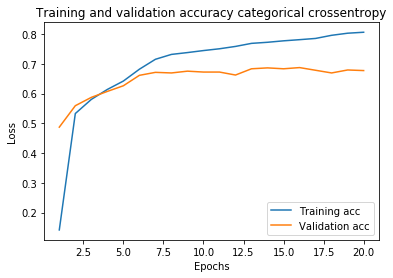

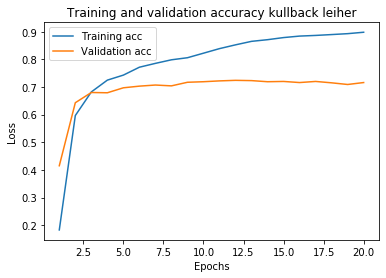

In [124]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy categorical crossentropy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy kullback leiher')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

kullback leiher is morre effective but less stable than categorical crossentropy

In [125]:
from sklearn.metrics import classification_report, confusion_matrix

print("categorical crossentropy")

pred_probabilities1 = model1.predict(x_test)
pred_labels1 = np.argmax(pred_probabilities1,-1)

cm = confusion_matrix(test_labels, pred_labels1)
print(cm)
print(classification_report(test_labels, pred_labels1))

print("kullback leiher")

pred_probabilities2 = model2.predict(x_test)
pred_labels2 = np.argmax(pred_probabilities2,-1)

cm = confusion_matrix(test_labels, pred_labels2)
print(cm)
print(classification_report(test_labels, pred_labels2))


categorical crossentropy
[[ 0  0  0 ...  0  0  0]
 [ 0 77  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.53      0.73      0.62       105
           2       0.00      0.00      0.00        20
           3       0.87      0.91      0.89       813
           4       0.74      0.86      0.80       474
           5       0.00      0.00      0.00         5
           6       0.09      0.07      0.08        14
           7       0.00      0.00      0.00         3
           8       0.33      0.42      0.37        38
           9       0.26      0.68      0.38        25
          10       0.21      0.27      0.23        30
          11       0.40      0.58      0.47        83
          12       0.00      0.00      0.00        13
          13       0.37      0.41      0.38        37
        

/Users/marek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 3  0  1 ...  0  0  0]
 [ 0 67  7 ...  0  0  0]
 [ 0  3 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  3 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.50      0.25      0.33        12
           1       0.54      0.64      0.58       105
           2       0.31      0.50      0.38        20
           3       0.85      0.91      0.88       813
           4       0.71      0.86      0.77       474
           5       0.00      0.00      0.00         5
           6       0.50      0.36      0.42        14
           7       0.00      0.00      0.00         3
           8       0.51      0.47      0.49        38
           9       0.53      0.64      0.58        25
          10       0.70      0.70      0.70        30
          11       0.53      0.53      0.53        83
          12       0.00      0.00      0.00        13
          13       0.40      0.27      0.32        37
          14       0.00      0.00

# 7. tanh vs relu

In [129]:
#1 relu

model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(46, activation='softmax'))

model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))
#1 than

model2 = models.Sequential()
model2.add(layers.Dense(64, activation='tanh', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='tanh'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 158us/step - loss: 3.1321 - accuracy: 0.2875 - val_loss: 2.4596 - val_accuracy: 0.3920
Epoch 2/20
7982/7982 [==============================] - 1s 105us/step - loss: 1.9629 - accuracy: 0.5326 - val_loss: 1.7101 - val_accuracy: 0.5970
Epoch 3/20
7982/7982 [==============================] - 1s 103us/step - loss: 1.4943 - accuracy: 0.6233 - val_loss: 1.5395 - val_accuracy: 0.6400
Epoch 4/20
7982/7982 [==============================] - 1s 121us/step - loss: 1.2876 - accuracy: 0.6769 - val_loss: 1.4368 - val_accuracy: 0.6540
Epoch 5/20
7982/7982 [==============================] - 1s 107us/step - loss: 1.1343 - accuracy: 0.7041 - val_loss: 1.3774 - val_accuracy: 0.6780
Epoch 6/20
7982/7982 [==============================] - 1s 103us/step - loss: 1.0140 - accuracy: 0.7509 - val_loss: 1.3528 - val_accuracy: 0.7000
Epoch 7/20
7982/7982 [==============================] - 1s 104us/step - loss

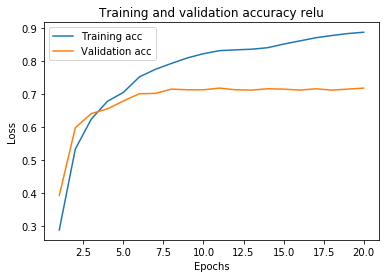

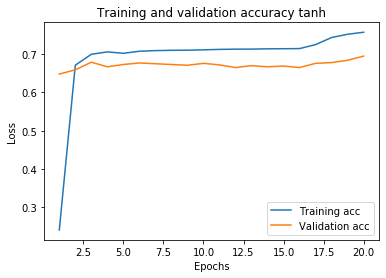

In [130]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy relu')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy tanh')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

tanh seems to be more stable but less effective

In [131]:
from sklearn.metrics import classification_report, confusion_matrix

print("relu")

pred_probabilities1 = model1.predict(x_test)
pred_labels1 = np.argmax(pred_probabilities1,-1)

cm = confusion_matrix(test_labels, pred_labels1)
print(cm)
print(classification_report(test_labels, pred_labels1))

print("tanh")

pred_probabilities2 = model2.predict(x_test)
pred_labels2 = np.argmax(pred_probabilities2,-1)

cm = confusion_matrix(test_labels, pred_labels2)
print(cm)
print(classification_report(test_labels, pred_labels2))


relu
[[ 5  0  0 ...  0  0  0]
 [ 0 67  0 ...  0  0  0]
 [ 0  1  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.59      0.64      0.61       105
           2       0.50      0.45      0.47        20
           3       0.86      0.92      0.88       813
           4       0.72      0.87      0.79       474
           5       0.00      0.00      0.00         5
           6       0.59      0.71      0.65        14
           7       1.00      0.33      0.50         3
           8       0.48      0.58      0.52        38
           9       0.28      0.20      0.23        25
          10       0.38      0.43      0.41        30
          11       0.45      0.60      0.52        83
          12       0.00      0.00      0.00        13
          13       0.33      0.24      0.28        37
          14       0.00     

/Users/marek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0  2  0 ...  0  0  0]
 [ 0 76  0 ...  0  0  0]
 [ 0 16  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.40      0.72      0.51       105
           2       0.00      0.00      0.00        20
           3       0.90      0.94      0.92       813
           4       0.76      0.87      0.81       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.36      0.47      0.41        38
           9       0.20      0.64      0.31        25
          10       0.00      0.00      0.00        30
          11       0.23      0.11      0.15        83
          12       0.00      0.00      0.00        13
          13       0.30      0.27      0.29        37
          14       0.00      0.00